In [1]:
from pathlib import Path
import os
import pandas as pd
ROOT = 0
ROOT = Path.cwd().parents[3]
os.chdir(ROOT)
df = pd.read_csv(ROOT/"data"/"processed"/"gdelt_ohlcv_join.csv")

In [2]:
df.head()

,seendate,url,title,language,domain,socialimage,company,ticker,sentiment_score,sentiment_hits,sentiment_present,article_date,price_date,next_open,next_high,next_low,next_close,next_adj_close,next_volume
0,2026-01-11 00:45:00+00:00,https://finance.yahoo.com/news/viasat-stock-bu...,Is Viasat Stock a Buy or Sell After the CEO So...,English,finance.yahoo.com,https://s.yimg.com/ny/api/res/1.2/ApxtKH_0tOj5...,Apple,AAPL,0.96,1.0,True,2026-01-11,2026-01-12,259.160004,261.299988,256.799988,260.25,260.006714,45263800
1,2026-01-11 01:15:00+00:00,https://finance.yahoo.com/news/why-warren-buff...,Why Warren Buffett Finally Bought Alphabet Shares,English,finance.yahoo.com,https://s.yimg.com/os/en/motleyfool.com/4716d7...,Apple,AAPL,0.96,1.0,True,2026-01-11,2026-01-12,259.160004,261.299988,256.799988,260.25,260.006714,45263800
2,2026-01-11 01:15:00+00:00,https://myhostnews.com/iphone-17e-iphone-18-pr...,"iPhone 17e , iPhone 18 Pro , iOS 27 , iPhone F...",English,myhostnews.com,https://myhostnews.com/wp-content/uploads/2026...,Apple,AAPL,0.76,1.0,True,2026-01-11,2026-01-12,259.160004,261.299988,256.799988,260.25,260.006714,45263800
3,2026-01-11 01:15:00+00:00,https://finance.yahoo.com/news/applied-optoele...,Is Applied Optoelectronics Stock a Buy or Sell...,English,finance.yahoo.com,https://s.yimg.com/ny/api/res/1.2/HkyrHDK309aB...,Apple,AAPL,0.96,1.0,True,2026-01-11,2026-01-12,259.160004,261.299988,256.799988,260.25,260.006714,45263800
4,2026-01-11 01:45:00+00:00,https://economictimes.indiatimes.com/markets/s...,Large - cap stocks : Buy right in 2026 & sit q...,English,economictimes.indiatimes.com,"https://img.etimg.com/thumb/msid-126452256,wid...",Apple,AAPL,0.91,4.0,True,2026-01-11,2026-01-12,259.160004,261.299988,256.799988,260.25,260.006714,45263800


In [3]:
print(df.columns)
print(df.shape)

Index(['seendate', 'url', 'title', 'language', 'domain', 'socialimage',
       'company', 'ticker', 'sentiment_score', 'sentiment_hits',
       'sentiment_present', 'article_date', 'price_date', 'next_open',
       'next_high', 'next_low', 'next_close', 'next_adj_close', 'next_volume'],
      dtype='str')
(1309, 19)


# Sentiment Signal & Disagreement Analysis

## What are we trying to figure out?

Instead of only looking at the *average* sentiment score, we want to know:

- Are there days when news coverage becomes heavily positive or heavily negative?
- Do these extreme days happen for one company, or multiple companies at the same time?
- Are extreme days caused by real events, or just a few websites posting a lot?
- Does disagreement increase with the number of articles released?

This notebook focuses on identifying unusual “one-sided” news days and investigating what might be driving them.


In [4]:
tickers = df["ticker"].unique()
print(tickers)

<ArrowStringArray>
['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Length: 7, dtype: str


## Step 1: Do sentiment scores look similar across companies?

Before building any “extreme day” rules, we check whether sentiment scores are roughly comparable across tickers.

If one company naturally has wider sentiment swings than others,
then we need to account for that when defining what “extreme” means.

In [5]:
g_ss = df.groupby("ticker")["sentiment_score"]
sent_rg = (g_ss.max() - g_ss.min()).rename("sentiment_range")
print(sent_rg)

ticker
AAPL     1.92
AMZN     1.96
GOOGL    1.92
META     1.92
MSFT     1.92
NVDA     1.92
TSLA     1.92
Name: sentiment_range, dtype: float64


In [6]:
sent_std = g_ss.std().rename("sentiment_std")
sent_std

ticker
AAPL     0.508578
AMZN     0.479773
GOOGL    0.480502
META     0.510481
MSFT     0.439929
NVDA     0.520915
TSLA     0.519599
Name: sentiment_std, dtype: float64

## Step 2: Measuring daily news balance

For each company and each day, we count:

- Number of positive articles
- Number of negative articles
- Net = positive − negative

We use this because averages can hide information.

Example:
If 50 articles are positive and 50 are negative, the average might look neutral.
But that’s very different from a day with only 2 neutral articles.

The net count tells us how one-sided the coverage really is.

In [7]:
g_t_ad = df.groupby(["ticker","article_date"])["sentiment_score"]
diff = g_t_ad.agg(
    positive = lambda x: (x >= 0).sum(),
    negative = lambda x: (x < 0).sum()
)
diff["net_polarity"] = diff["positive"] - diff["negative"]
diff

positive  negative  net_polarity
ticker article_date                                  
AAPL   2026-01-11          23         3            20
       2026-01-12          40         3            37
       2026-01-27          11         1            10
       2026-02-03          13         0            13
       2026-02-09          31         4            27
AMZN   2026-01-11          12         2            10
       2026-01-12          27         0            27
       2026-01-13          16         3            13
       2026-01-27           9         0             9
       2026-02-03           5         0             5
       2026-02-04           3         0             3
       2026-02-09          30         5            25
GOOGL  2026-01-11           9         0             9
       2026-01-12          18         2            16
       2026-01-13          28         1            27
       2026-01-27          13         0            13
       2026-02-03          13         6             7
       2026-02-04           6         1             5
       2026-02-07          27         4            23
       2026-02-08          40         3            37
       2026-02-09          68         7            61
META   2026-01-11          15         0            15
       2026-01-12          23         6            17
       2026-01-13          62         6            56
       2026-01-14          28         2            26
       2026-01-27           9         0             9
       2026-02-03           9         0             9
       2026-02-04           3         0             3
       2026-02-06          57        19            38
       2026-02-07          39         9            30
       2026-02-08          24         6            18
       2026-02-09          32         4            28
MSFT   2026-01-11          16         0            16
       2026-01-12          23         4            19
       2026-01-13          23         0            23
       2026-01-27          14         2            12
       2026-02-03          14         0            14
       2026-02-09          38         2            36
NVDA   2026-01-11          44         0            44
       2026-01-12          50         2            48
       2026-01-13          22         1            21
       2026-01-27          22         1            21
       2026-02-03           8         1             7
       2026-02-04           2         0             2
       2026-02-09          68        12            56
TSLA   2026-01-11          13         5             8
       2026-01-12          16         2            14
       2026-01-13          13         0            13
       2026-01-27          14         1            13
       2026-02-03           3         1             2
       2026-02-07           6         1             5
       2026-02-08          14         1            13
       2026-02-09           8         2             6

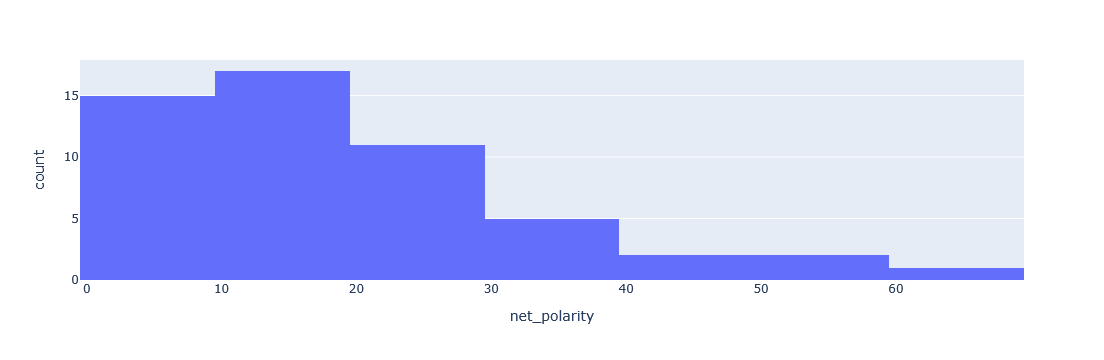

In [8]:
import plotly.express as px
px.histogram(diff, x = "net_polarity")

## Step 3: Defining “extreme” days

We want a simple way to detect unusually one-sided days.

We use the IQR method (a common outlier rule):

- Calculate Q1 and Q3 of daily net sentiment for each ticker
- Compute the IQR (Q3 - Q1)
- Flag days that fall far outside the normal range

We do this on a per-ticker basis because different companies naturally receive different amounts of coverage.
An “extreme” day for Apple might not be extreme for another stock.

In [46]:
def outliers(df_: pd.DataFrame, column: str):
    qs = (
        df_.groupby("ticker")[column]
        .quantile([0.25, 0.75])
        .unstack()
        .rename(columns={0.25: "q1", 0.75: "q3"})
    )
    qs["iqr"] = qs["q3"] - qs["q1"]
    qs[f"{column}_lower"] = qs["q1"] - (1.5 * qs["iqr"])
    qs[f"{column}_upper"] = qs["q3"] + (1.5 * qs["iqr"])
    df_2 = df_.join(qs[[f"{column}_lower", f"{column}_upper"]], on="ticker")
    outliers = df_2[ (df_2[column]<=df_2[f"{column}_lower"]) | (df_2[column]>=df_2[f"{column}_upper"]) ]
    return outliers
diff = diff.sort_values("article_date").reset_index()
xtrm_pol = outliers(diff,"net_polarity")

In [47]:
xtrm_pol

,level_0,index,ticker,article_date,positive,negative,net_polarity,net_polarity_lower,net_polarity_upper
16,16,16,META,2026-01-13,62,6,56,-13.50,54.50
48,48,48,GOOGL,2026-02-09,68,7,61,-18.00,54.00
50,50,50,MSFT,2026-02-09,38,2,36,3.25,33.25


## What extreme days did we find?

Only a few ticker-days are flagged as extreme.

Interestingly, two companies spike on the same day.

This raises an important question:

Is this a broader market-wide news day?
Or is it just coincidence?

To explore that, we now look at which domains were publishing heavily on those days.

In [14]:
xdf=df.merge(xtrm_pol[["article_date","ticker"]], how="inner", on=["article_date","ticker"], )

## Step 4: Checking domain activity on extreme days

An extreme day might happen for two reasons:

1) A major real event (many outlets covering it)
2) A few high-volume websites publishing repeatedly

To test this, we count how many articles each domain published on extreme days.

In [15]:
xdomains=xdf.groupby(["article_date","domain"]).size()
xdomains=(xdomains.reset_index(name="count")
     )
xdomains

,article_date,domain,count
0,2026-01-13,abcnews.go.com,1
1,2026-01-13,aol.com,1
2,2026-01-13,benzinga.com,4
3,2026-01-13,bnnbloomberg.ca,1
4,2026-01-13,bostonglobe.com,1
...,...,...,...
77,2026-02-09,timesofindia.indiatimes.com,1
78,2026-02-09,wccftech.com,1
79,2026-02-09,webpronews.com,5
80,2026-02-09,windowscentral.com,1


In [16]:
nx_df=df.merge(
    xtrm_pol[["article_date","ticker"]]
    , how="left"
    , on=["article_date","ticker"]
    ,indicator=True
)
nx_df = nx_df[nx_df["_merge"] == "left_only"]

In [17]:
domains=(
    nx_df.groupby(["article_date","domain"]).size()
    .reset_index(name="count")
)
filtered_domains=domains.merge(xdomains["domain"], how = "inner", on="domain")
fdomains_mean=filtered_domains.groupby("domain")["count"].mean()
fdomains_mean=fdomains_mean.reset_index(name="average")
fdomains_mean

,domain,average
0,abcnews.go.com,1.000000
1,afr.com,1.000000
2,aol.com,2.000000
3,benzinga.com,3.600000
4,bnnbloomberg.ca,2.000000
5,businessinsider.com,1.250000
6,cantechletter.com,1.000000
7,cnbc.com,2.250000
8,cointelegraph.com,1.000000
9,cyprus-mail.com,1.000000


In [18]:
xdomains=xdomains.merge(fdomains_mean[["domain","average"]], on = "domain", how = "left")
xdomains

,article_date,domain,count,average
0,2026-01-13,abcnews.go.com,1,1.0
1,2026-01-13,aol.com,1,2.0
2,2026-01-13,benzinga.com,4,3.6
3,2026-01-13,bnnbloomberg.ca,1,2.0
4,2026-01-13,bostonglobe.com,1,NaN
...,...,...,...,...
77,2026-02-09,timesofindia.indiatimes.com,1,1.6
78,2026-02-09,wccftech.com,1,1.0
79,2026-02-09,webpronews.com,5,8.0
80,2026-02-09,windowscentral.com,1,NaN


## Step 5: Comparing extreme day volume to normal volume

To understand whether a domain is unusually active,
we compare its article count on the extreme day
to its typical daily average.

If a domain posts much more than usual,
it may be amplifying the signal.

If activity is normal,
the extreme day is less likely to be caused by just one publisher.

In [19]:
xdomains.loc[xdomains["count"] > xdomains["average"]]

,article_date,domain,count,average
2,2026-01-13,benzinga.com,4,3.600000
16,2026-01-13,fool.co.uk,2,1.500000
19,2026-01-13,fortune.com,2,1.500000
22,2026-01-13,insidermonkey.com,2,1.500000
52,2026-02-09,cnbc.com,3,2.250000
54,2026-02-09,economictimes.indiatimes.com,4,2.888889
57,2026-02-09,finanznachrichten.de,3,2.400000
59,2026-02-09,fool.com,16,9.400000
69,2026-02-09,markets.financialcontent.com,41,12.428571
70,2026-02-09,marketscreener.com,4,2.333333


In [20]:
xdomains.loc[xdomains["count"] <= xdomains["average"]]

,article_date,domain,count,average
0,2026-01-13,abcnews.go.com,1,1.000000
1,2026-01-13,aol.com,1,2.000000
3,2026-01-13,bnnbloomberg.ca,1,2.000000
6,2026-01-13,cnbc.com,1,2.250000
7,2026-01-13,cointelegraph.com,1,1.000000
8,2026-01-13,dailypolitical.com,1,2.666667
9,2026-01-13,deccanchronicle.com,1,1.000000
10,2026-01-13,eastbaytimes.com,1,1.000000
12,2026-01-13,el-balad.com,2,2.125000
14,2026-01-13,finance.yahoo.com,5,18.363636


## Step 6: One-sidedness vs intensity (two different ideas)

So far, our main metric was:

**net = positive − negative**

This tells us **one-sidedness**:
- big positive net → mostly positive articles that day  
- big negative net → mostly negative articles that day  
- near 0 → mixed day (or low volume)

But net does *not* tell us how “strong” the sentiment was.

Example:
- 50 slightly-positive articles → big net, but low intensity
- 50 extremely-positive articles → big net, high intensity

So now we add a second idea:

### Sentiment intensity (how spread out the scores are)
We measure intensity using:
- **`sentiment_score_std`** (standard deviation of sentiment scores per ticker-day)

Interpretation:
- low std → articles cluster around similar sentiment strength
- high std → articles range from mild to extreme (more spread)

Now we can compare:
one-sidedness (net) vs intensity (std)

In [21]:
domain_vol=df.groupby(["article_date","ticker"])["domain"].count().reset_index(name="volume")
sentiment_score_std=df.groupby(["article_date","ticker"])["sentiment_score"].std().reset_index(name="sentiment_score_std")

diff_vs_vol=diff

diff_vs_vol=diff_vs_vol.merge(sentiment_score_std, on=["article_date","ticker"])
diff_vs_vol=diff_vs_vol.merge(domain_vol, on=["article_date","ticker"])
diff_vs_vol

,ticker,article_date,positive,negative,net_polarity,sentiment_score_std,volume
0,AAPL,2026-01-11,23,3,20,0.598248,26
1,AMZN,2026-01-11,12,2,10,0.573413,14
2,GOOGL,2026-01-11,9,0,9,0.490309,9
3,META,2026-01-11,15,0,15,0.451374,15
4,MSFT,2026-01-11,16,0,16,0.212500,16
5,NVDA,2026-01-11,44,0,44,0.455485,44
6,TSLA,2026-01-11,13,5,8,0.561018,18
7,AAPL,2026-01-12,40,3,37,0.490942,43
8,AMZN,2026-01-12,27,0,27,0.343113,27
9,GOOGL,2026-01-12,18,2,16,0.467333,20


In [22]:
plot_df=diff_vs_vol[diff_vs_vol["volume"]>=2]

## Volume vs Sentiment Variability

Here we examine whether days with more articles also have higher disagreement.

If higher volume causes more disagreement,
we should see a clear upward trend in this scatter plot.

If not, then disagreement may be driven by something else.


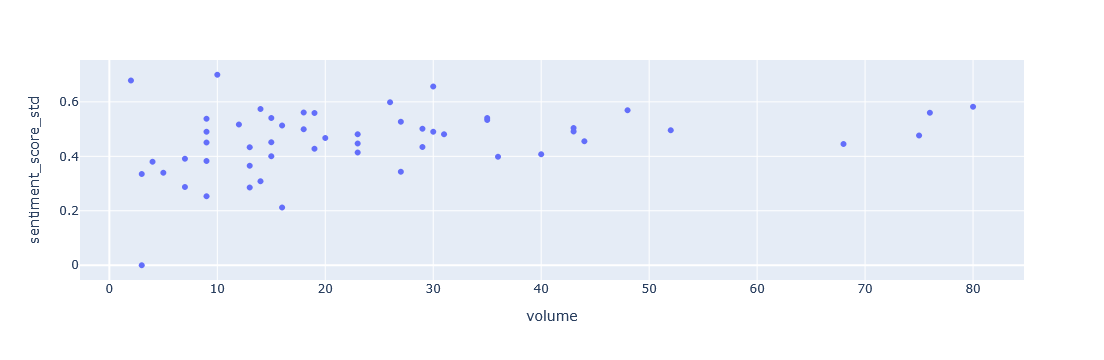

In [23]:
import plotly.express as px
px.scatter(plot_df, x = "volume", y = "sentiment_score_std")

### Initial Observations

Most tickers show a **positive correlation** between volume and sentiment variability.

This suggests that when more articles are published,
sentiment disagreement tends to increase.

However:

- The strength of the relationship varies.
- NVDA even shows a slightly negative relationship.

This tells us volume alone does not fully explain disagreement.

In [24]:
corrs = (plot_df.groupby("ticker")
                         .apply(lambda x: x["volume"].corr(x["sentiment_score_std"]))
)
print(corrs.round(3))

ticker
AAPL     0.420
AMZN     0.539
GOOGL    0.458
META     0.551
MSFT     0.332
NVDA    -0.148
TSLA     0.296
dtype: float64


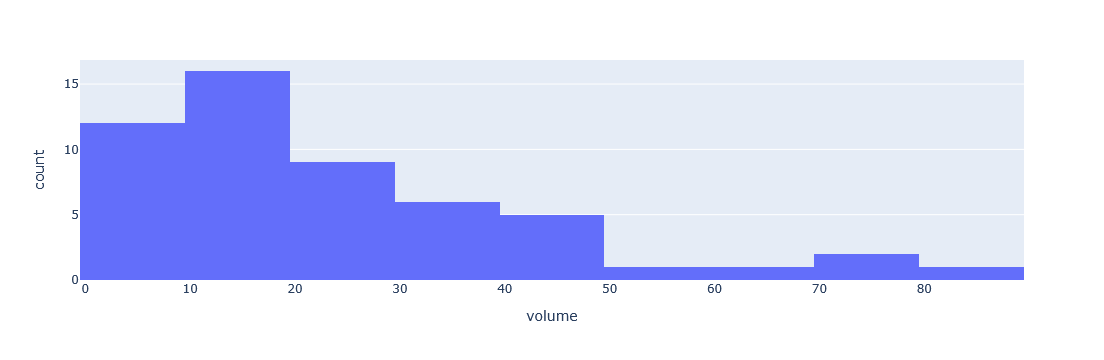

In [25]:
import numpy as np
px.histogram(plot_df, x="volume")

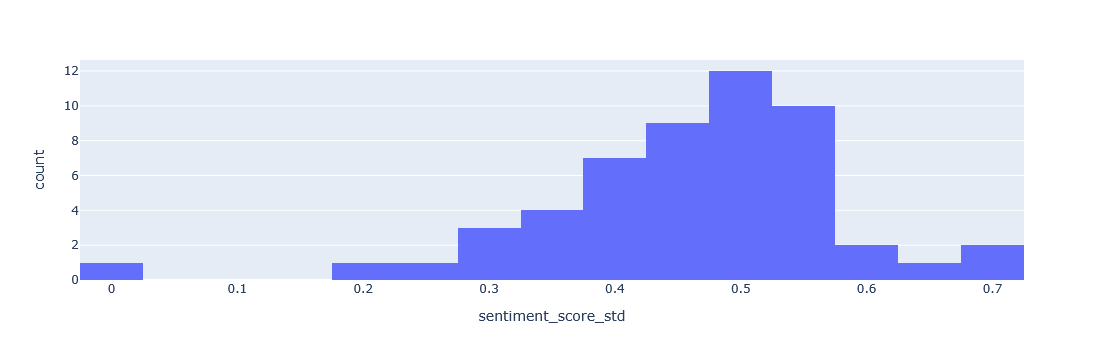

In [26]:
px.histogram(plot_df, x="sentiment_score_std")

## Adjusting for skewed volume

Article volume is very skewed:
- most ticker-days have moderate volume
- a few ticker-days have very high volume

Because correlation can be influenced by extreme values, we try log transform on volume and net polarity:

- `log1p(volume)` compresses the big days so they don’t dominate.
- `log1p(net_polarity)` compresses the extremely positive days 

### Important note:
We do **not** log-transform `sentiment_score_std`.

- standard deviation is already on a small, bounded scale here
- it’s not exploding like volume
- logging it would skew interpretation


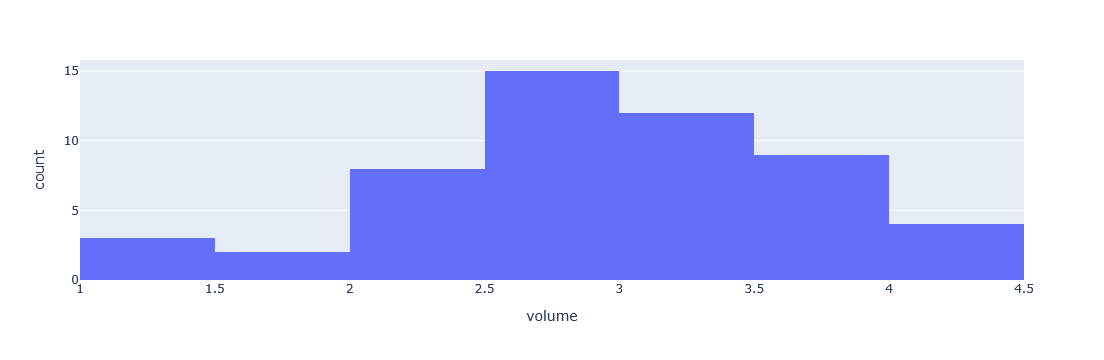

In [27]:
px.histogram(np.log1p(plot_df["volume"]), x="volume")

In [28]:
std_corrs = (plot_df.groupby("ticker")
                         .apply(lambda x: np.log1p(x["volume"]).corr(x["sentiment_score_std"]))
)
print(std_corrs.round(3))

ticker
AAPL     0.479
AMZN     0.716
GOOGL    0.590
META     0.668
MSFT     0.401
NVDA    -0.552
TSLA     0.332
dtype: float64


In [29]:
pd.concat([plot_df, diff.reset_index().sort_values("article_date")])
polarity_corrs = (plot_df.groupby("ticker")
                         .apply(lambda x: np.log1p(x["volume"]).corr(np.log10(x["net_polarity"])))
)
print(polarity_corrs.round(3))

ticker
AAPL     0.985
AMZN     0.982
GOOGL    0.929
META     0.973
MSFT     0.921
NVDA     0.994
TSLA     0.915
dtype: float64


### After Log Adjustment

After adjusting for skewness, correlations generally increase for std.

This suggests:
The relationship between volume and disagreement is not purely driven by outliers.

However, disagreement is still not perfectly explained by volume. There are likely event-driven factors at play.

---

The correlations between log(volume) and log(net polarity) are extremely high (above 0.9 for all tickers).

This suggests that net polarity is strongly tied to article volume.

This is not surprising.

Because net polarity is calculated using counts (positive − negative), it naturally scales with total volume.

As volume increases:
- The number of positive articles increases
- The number of negative articles increases
- The net difference can grow proportionally

This means polarity, as currently defined, is volume-sensitive.

Therefore, high correlation here reflects structural scaling, not necessarily deeper market dynamics.

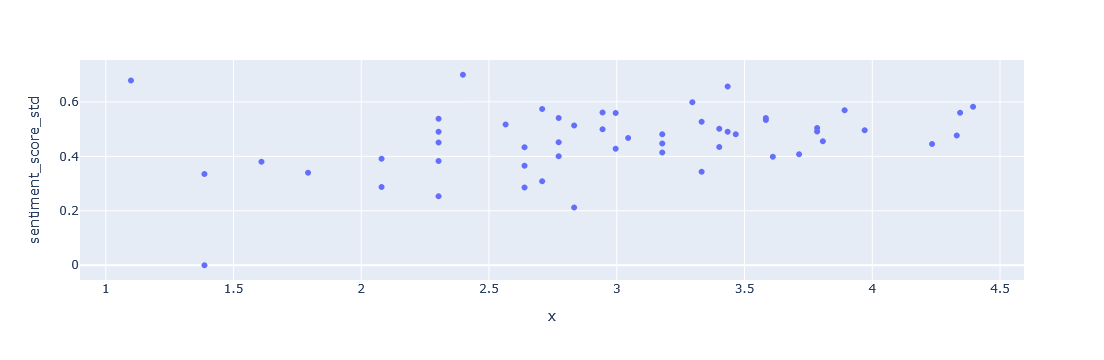

In [30]:
px.scatter(plot_df, x = np.log1p(plot_df["volume"]), y = plot_df["sentiment_score_std"])

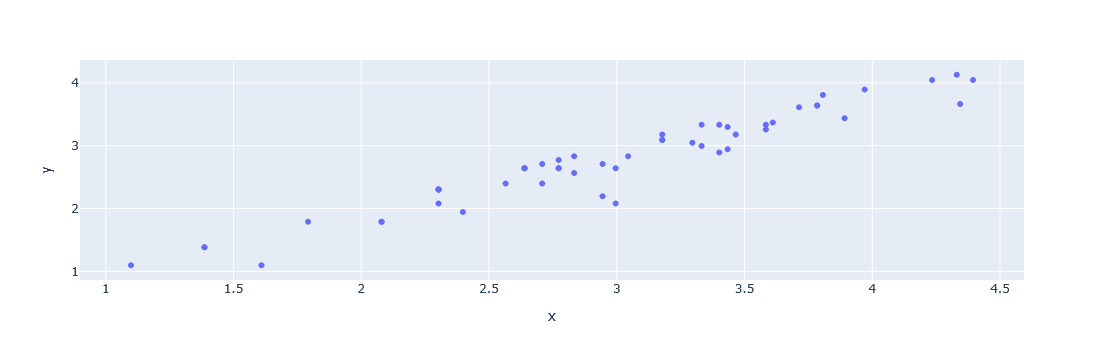

In [31]:
px.scatter(plot_df, x = np.log1p(plot_df["volume"]), y = np.log1p(plot_df["net_polarity"]))

In [32]:
plot_df["net_polarity_ratio"]=plot_df["net_polarity"]/plot_df["volume"]
net_polarity_ratio_corr = (plot_df.groupby(["ticker"])
                                    .apply(lambda x: x["net_polarity_ratio"].corr(np.log10(x["volume"])))
)
print(net_polarity_ratio_corr)

ticker
AAPL    -0.511510
AMZN    -0.589878
GOOGL   -0.041586
META    -0.753116
MSFT    -0.248583
NVDA    -0.359339
TSLA     0.373518
dtype: float64


## Volume vs Directional Bias (Net Ratio)

Unlike raw net counts, net_ratio removes scale effects.

The correlations here show that for most tickers,
higher volume is associated with lower directional purity.

This suggests that large news days tend to bring more balanced coverage,
while smaller news days may appear more one-sided.

Raw polarity scales with volume,
but proportional bias does not necessarily increase with attention.

## Step 7: Direction vs Intensity (Using Both Raw and Ratio Polarity)

So far, we have measured one-sidedness in two ways:

1) **Raw Polarity (net = positive − negative)**  
   - Captures absolute narrative force.
   - Strongly influenced by volume.

2) **Polarity Ratio (net_ratio = net / volume)**  
   - Captures directional purity.
   - Adjusted for scale effects.

Both describe direction — but from different perspectives.

Now we ask a new question:

> When a day is directionally extreme (either in raw net or net_ratio), is it also unusually intense?

Intensity here is measured using:

- **`sentiment_score_std`** (the dispersion of sentiment scores within that ticker-day)

Why this matters:

A one-sided day could look very different internally:

- Many mildly-positive articles - high ratio, low intensity
- Many strongly-positive articles - high ratio, high intensity
- High raw net but average ratio - amplification without unusual bias

So we build IQR-based outlier thresholds for:

- raw net
- net_ratio
- sentiment_score_std

Then we compare:

- Are raw polarity outliers also intensity outliers?
- Are ratio polarity outliers also intensity outliers?
- Or do these represent structurally different types of days?


In [48]:
xtrm_pol

,level_0,index,ticker,article_date,positive,negative,net_polarity,net_polarity_lower,net_polarity_upper
16,16,16,META,2026-01-13,62,6,56,-13.50,54.50
48,48,48,GOOGL,2026-02-09,68,7,61,-18.00,54.00
50,50,50,MSFT,2026-02-09,38,2,36,3.25,33.25


In [41]:
diff_vs_vol["net_polarity_ratio"]=plot_df["net_polarity_ratio"]
xtrm_std = outliers(diff_vs_vol,"sentiment_score_std")

In [42]:
xtrm_std

,ticker,article_date,positive,negative,net_polarity,sentiment_score_std,volume,net_polarity_ratio,sentiment_score_std_lower,sentiment_score_std_upper
0,AAPL,2026-01-11,23,3,20,0.598248,26,0.769231,0.426713,0.597992
28,AAPL,2026-02-03,13,0,13,0.285406,13,1.000000,0.426713,0.597992
35,AMZN,2026-02-04,3,0,3,0.000000,3,1.000000,0.028592,0.863008
36,GOOGL,2026-02-04,6,1,5,0.287253,7,0.714286,0.363001,0.551625


In [45]:
xtrm_pol_ratio = outliers(diff_vs_vol,"net_polarity_ratio")
xtrm_pol_ratio

,ticker,article_date,positive,negative,net_polarity,sentiment_score_std,volume,net_polarity_ratio,net_polarity_ratio_lower,net_polarity_ratio_upper
28,AAPL,2026-02-03,13,0,13,0.285406,13,1.000000,0.637874,0.994020
30,GOOGL,2026-02-03,13,6,7,0.428218,19,0.368421,0.458287,1.214683


# Final Conclusion: Three Distinct Types of Unusual News Days

This analysis reveals that “unusual” ticker-days do not all look the same.

Instead, we observe three structurally different types of outliers.

---

## 1️⃣ Raw Polarity Outliers (Magnitude Days)

These are days where:

- `net_polarity = positive − negative`
- Falls outside its normal range.

These days reflect strong **narrative force**. They are typically associated with high article volume.

Because raw polarity scales with volume, these outliers often capture attention expansion and amplified directional pressure.

---

## 2️⃣ Polarity Ratio Outliers (Directional Purity Days)

These are days where:

- `net_polarity_ratio = net / volume`
- Falls outside its normal range.

These days reflect **unusually strong directional bias**, independent of scale.

They are not necessarily high-volume days.

These capture the purity of sentiment, rather than the magnitude.

---

## 3️⃣ Intensity Outliers (Dispersion Days)

These are days where:

- `sentiment_score_std`
- Falls outside its IQR thresholds.

These days reflect unusual **sentiment spread**.

They capture emotional dispersion — not direction.

---

## Key Structural Insight

The three outlier types behave differently:

- Raw polarity outliers (net) did not overlap with intensity outliers.
- Polarity ratio outliers overlapped with intensity outliers in at least one case.
- Most outliers remain isolated to one dimension.

This suggests:

When polarity ratio and intensity overlap, it may represent a rare “consensus day” — where coverage is both directionally aligned and internally consistent in sentiment strength.

These overlapping cases are sparse, which may make them structurally more interesting than isolated outliers.

---

## Interpretation

Raw polarity appears strongly tied to volume.
This is expected, since it is count-based.

Polarity ratio removes scale effects and better captures structural bias.

Intensity (std) measures how varied sentiment strength is within the day.

Together, these three metrics form a multi-dimensional view of news structure.

---

## Limitations and Reflection

Although this notebook provides useful structural separation, the findings are not overwhelming.

Financial news appears positively skewed most of the time.

As article volume increases, raw positive counts tend to increase as well, making magnitude-based outliers partly mechanical.

Additionally, isolated daily outliers (e.g., a 13–0 day for AAPL) are interesting but insufficient to draw broader conclusions.

Single days do not establish persistent narrative shifts.

---

## Next Direction

Future analysis should consider:

- Weekly or rolling sentiment aggregates
- Consecutive-day clustering of outliers
- Regime detection across longer horizons

Outliers may become more meaningful if they persist across multiple days, rather than appearing in isolation.